# WIP: Balance Dataset (All Data)

In [1]:
!pip install -q PyAthena==1.10.7

In [2]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [3]:
import boto3
import sagemaker
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [38]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

# Set Athena database & table 
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'

# TODO: Download all data into S3 bucket

# Number of Reviews per Product Category and Star Rating? 

In [6]:
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [7]:
cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

In [8]:
df = as_pandas(cursor)
df

,product_category,star_rating,count_reviews
0,Apparel,5,3320566
1,Apparel,4,1147237
2,Apparel,3,623471
3,Apparel,2,369601
4,Apparel,1,445458
...,...,...,...
210,Wireless,5,4824783
211,Wireless,4,1501327
212,Wireless,3,815205
213,Wireless,2,598330


# Balance the Dataset

## Find min() number of Reviews per Star Rating (grouped by Star Rating)

In [14]:
df_sum = df.groupby(['star_rating']).sum()
print(df_sum)

review_minimum = df_sum['count_reviews'].min()
print("\n Minimum number of reviews: " + str(review_minimum))

             count_reviews
star_rating               
1                 12099639
2                  7304430
3                 12133927
4                 26223470
5                 93200812

 Minimum number of reviews: 7304430


## Find absolute min() number of Reviews per Star Rating (across Product Categories)

In [17]:
df_min = df.loc[df.groupby('star_rating')['count_reviews'].idxmin()]
print(df_min)

review_minimum_2 = df_min['count_reviews'].min()
print("\n Minimum number of reviews: " + str(review_minimum_2))

    product_category  star_rating  count_reviews
69         Gift Card            1           4793
68         Gift Card            2           1569
67         Gift Card            3           3156
66         Gift Card            4           9859
40  Digital_Software            5          46410

 Minimum number of reviews: 1569


# Pick number N (min) of Reviews per Star Rating 

## ---- Using Stratified Reservoir Sampling ----
See https://ragrawal.wordpress.com/2017/08/11/data-sampling-in-presto/  
Select min() number of reviews (randomized) from each star rating group. 

In [18]:
statement = """SELECT star_rating,
         review_body,
         product_category
FROM 
    (SELECT *,
         ROW_NUMBER()
        OVER (PARTITION BY star_rating
    ORDER BY  rnd) AS rnk
    FROM 
        (SELECT star_rating,
         review_body,
         product_category,
         RANDOM() AS rnd
        FROM dsoaws.amazon_reviews_parquet ) bucketed ) sampled
    WHERE rnk <= 100
"""

print(statement)

SELECT star_rating,
         review_body,
         product_category
FROM 
    (SELECT *,
         ROW_NUMBER()
        OVER (PARTITION BY star_rating
    ORDER BY  rnd) AS rnk
    FROM 
        (SELECT star_rating,
         review_body,
         product_category,
         RANDOM() AS rnd
        FROM dsoaws.amazon_reviews_parquet ) bucketed ) sampled
    WHERE rnk <= 100



In [19]:
cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

In [20]:
df_balanced = as_pandas(cursor)
df_balanced.head()

,star_rating,review_body,product_category
0,5,Found a Wiha phillips #2 in my ally back in th...,Tools
1,5,"Excellent, works as it should. You may have to...",Lawn and Garden
2,5,"Very nice item, my grandbaby in love with her ...",Apparel
3,5,The inside of the hard part looks like it was ...,Wireless
4,5,This game is great to keep your mind active an...,Mobile_Apps


## CHECK: Number of Reviews per Star Rating

Text(0, 0.5, 'Review Count')

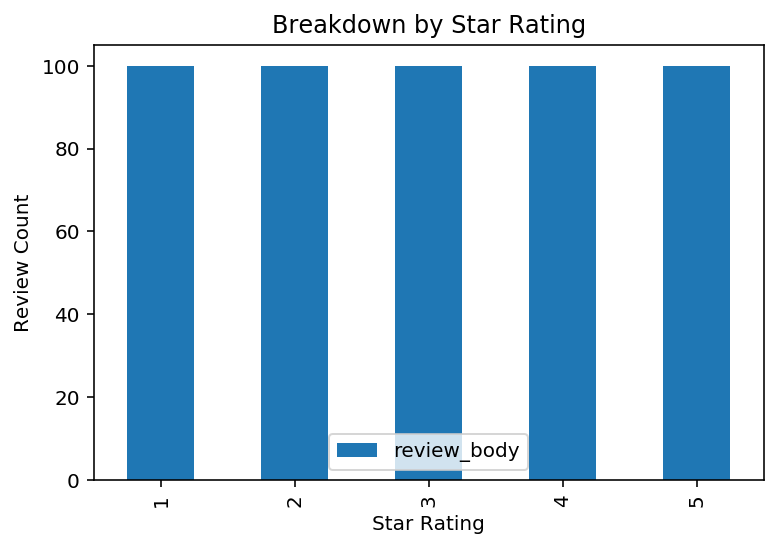

In [22]:
df_balanced[['star_rating', 'review_body']].groupby('star_rating').count().plot(kind='bar', title='Breakdown by Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')

## ---- Using Athena CTAS Query ----

In [36]:
def sample_reviews(num_samples):
    for star in range(1,6,1):
        statement = """
        CREATE TABLE IF NOT EXISTS dsoaws.amazon_reviews_sampled_star{}
        WITH ( format = 'TEXTFILE', external_location = 's3://{}/amazon-reviews-pds/sampled/star{}', field_delimiter = '\\t' ) AS
        SELECT review_body,
                 product_category,
                 star_rating
        FROM dsoaws.amazon_reviews_parquet TABLESAMPLE BERNOULLI (1)
        WHERE star_rating = {}
        LIMIT {}
        """.format(str(star), bucket, str(star), star, num_samples)
        print("-------------- EXECUTING NOW: ----------------------")
        print(statement)
        cursor = connect(region_name=region, s3_staging_dir=s3_staging_dir).cursor()
        cursor.execute(statement)
        print("-------------- EXECUTION FINISHED ------------------")
    print("DONE.")


In [37]:
sample_reviews(10000)

-------------- EXECUTING NOW -----------------------

        CREATE TABLE IF NOT EXISTS dsoaws.amazon_reviews_sampled_star1
        WITH ( format = 'TEXTFILE', external_location = 's3://sagemaker-us-east-1-806570384721/amazon-reviews-pds/sampled/star1', field_delimiter = '\t' ) AS
        SELECT review_body,
                 product_category,
                 star_rating
        FROM dsoaws.amazon_reviews_parquet TABLESAMPLE BERNOULLI (1)
        WHERE star_rating = 1
        LIMIT 10000
        
-------------- EXECUTING FINISHED ------------------
-------------- EXECUTING NOW -----------------------

        CREATE TABLE IF NOT EXISTS dsoaws.amazon_reviews_sampled_star2
        WITH ( format = 'TEXTFILE', external_location = 's3://sagemaker-us-east-1-806570384721/amazon-reviews-pds/sampled/star2', field_delimiter = '\t' ) AS
        SELECT review_body,
                 product_category,
                 star_rating
        FROM dsoaws.amazon_reviews_parquet TABLESAMPLE BERNOULLI (1)


# TODO: Combine 5x TSV Files in Query

# Set up BERT feature engineering pipeline

In [ ]:
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q transformers==2.8.0
!pip install -q tensorflow==2.1.0

In [ ]:
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

DATA_COLUMN = 'review_body'
LABEL_COLUMN = 'star_rating'
LABEL_VALUES = [1, 2, 3, 4, 5]

label_map = {}
for (i, label) in enumerate(LABEL_VALUES):
    label_map[label] = i

    
class InputFeatures(object):
  """BERT feature vectors."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    
    
class Input(object):
  """A single training/test input for sequence classification."""

  def __init__(self, text, label=None):
    """Constructs an Input.
    Args:
      text: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.text = text
    self.label = label
    

def convert_input(text_input, max_seq_length):
    # First, we need to preprocess our data so that it matches the data BERT was trained on:
    # 1. Lowercase our text (if we're using a BERT lowercase model)
    # 2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
    # 3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
    # 
    # Fortunately, the Transformers tokenizer does this for us!

    tokens = tokenizer.tokenize(text_input.text)
    print('**tokens**\n{}\n'.format(tokens))

    encode_plus_tokens = tokenizer.encode_plus(text_input.text,
                                               pad_to_max_length=True,
                                               max_length=max_seq_length)

    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens['input_ids']
    
    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.    
    input_mask = encode_plus_tokens['attention_mask']

    # Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.
    segment_ids = [0] * max_seq_length

    # Label for each training row (`star_rating` 1 through 5)
    label_id = label_map[text_input.label]

    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id)

    print('**input_ids**\n{}\n'.format(features.input_ids))
    print('**input_mask**\n{}\n'.format(features.input_mask))
    print('**segment_ids**\n{}\n'.format(features.segment_ids))
    print('**label_id**\n{}\n'.format(features.label_id))

    return features


# We'll need to transform our data into a format that BERT understands.
# - `text` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
# - `label` is the star_rating label (1, 2, 3, 4, 5) for our training input data
def transform_inputs_to_tfrecord(inputs, max_seq_length):
    tf_records = []
    for (input_idx, text_input) in enumerate(inputs):
      if input_idx % 10000 == 0:
          print('Writing input {} of {}\n'.format(input_idx, len(inputs)))

      features = convert_input(text_input, max_seq_length)
        
      all_features = collections.OrderedDict()
      all_features['input_ids'] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
      all_features['input_mask'] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
      all_features['segment_ids'] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
      all_features['label_ids'] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

      tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
      tf_records.append(tf_record.SerializeToString())

    return tf_records


# Choose a `max_seq_length` for BERT
Since a smaller `max_seq_length` leads to faster training and lower resource utilization, we want to find the smallest review length that captures `70%` of our reviews.

Remember our distribution of review lengths from a previous section?

```
mean         67.930174
std         130.954079
min           1.000000
10%           4.000000
20%          14.000000
30%          21.000000
40%          25.000000
50%          31.000000
60%          42.000000
70%          59.000000
80%          87.000000
90%         149.000000
100%       5347.000000
max        5347.000000
```

![](img/review_word_count_distribution.png)

Review length `59` represents the `70th` percentile for this dataset.  However, it's best to stick with powers-of-2 when using BERT.  So let's choose `64` as this is the smallest power-of-2 greater than `59`.  Reviews with length > `64` will be truncated to `64`.

In [ ]:
max_seq_length = 64

Three(3) feature vectors are created from each raw review (`review_body`) during the feature engineering phase to prepare for BERT processing:

* **`input_ids`**:  The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    
* **`input_mask`**:  Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.

* **`segment_ids`**:  Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.

And one(1) label is created from each raw review (`star_rating`)  :

* **`label_id`**:  Label for each training row (`star_rating` 1 through 5)

# Demonstrate the BERT-specific Feature Engineering Step
While we are demonstrating this code with a small amount of data here in the notebook, we will soon scale this to much more data on a powerful SageMaker cluster.

In [ ]:
import pandas as pd

data = [
        [5,"""I needed an antivirus application and know the quality of Norton products.  This was a no brainer for me and I am glad it was so simple to get."""],
        [3,"""The problem with ElephantDrive is that it requires the use of Java. Since Java is notorious for security problems I haveit removed from all of my computers. What files I do have stored are photos."""],
        [1,"""Terrible, none of my codes worked, and I can't uninstall it.  I think this product IS malware and viruses"""]
       ]

df = pd.DataFrame(data, columns=['star_rating','review_body'])

# Use the InputExample class from BERT's run_classifier code to create examples from the data
inputs = df.apply(lambda x: Input(text = x[DATA_COLUMN], 
                                  label = x[LABEL_COLUMN]), 
                  axis = 1)

tf_records = transform_inputs_to_tfrecord(inputs, max_seq_length)

The three(3) features vectors and one(1) label are converted into a list of `TFRecord` instances (1 per each row of training data):
* **`tf_records`**:  Binary representation of each row of training data (3 features + 1 label)

These `TFRecord`s are the engineered features that we will use throughout the rest of the pipeline.

In [ ]:
print('**tf_records**')

for tf_record in tf_records:
    print(tf_record)

In [ ]:
%%javascript
Jupyter.notebook.save_checkpoint();
Jupyter.notebook.session.delete();